# Models

> Collection of model architectures and related utilities.

In [22]:
#| default_exp models

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
#| export
from torch import optim, nn
from functools import partial

import matplotlib.pyplot as plt
import fastcore.all as fc

import torch
from torch.nn import init
import torchvision.transforms.functional as TF,torch.nn.functional as F

## Activations

In [25]:
#| export
class GeneralRelu(nn.Module):
    "Relu unit as implemented in Fastai miniai package: https://github.com/fastai/minai"
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv

    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None:
            x -= self.sub
        if self.maxv is not None:
            x.clamp_max_(self.maxv)
        return x

In [26]:
#| export
def plot_func(f, start=-5., end=5., steps=100, size=(5, 3)):
    "Plot a function (e.g activation function)."
    plt.figure(figsize=size)
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

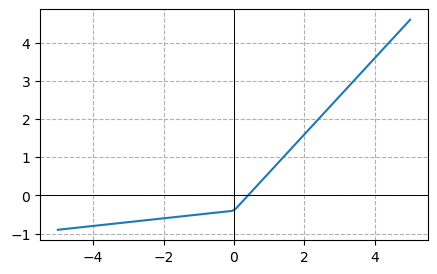

In [27]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

## Initialization

In [28]:
#| export
def init_weights(m, leaky=0.):
    "Initialize weights using kaiming normal method if Conv1d, ..., Linear."
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
        init.kaiming_normal_(m.weight, a=leaky)

## Layers

In [29]:
#| export
def conv(
    ni: int, # Number of input channels
    nf: int, # Number of output channels 
    ks:int=3, # Kernel size
    stride:int=2, # Stride
    dim:int=1, # Convolution dimension (1 or 2)
    act:nn.Module=nn.ReLU, # Activation function
    norm:nn.Module=None, # Normalization layer type
    bias:bool=None, # Is bias needed?
    ):
    "Wrapping `torch.Conv1D` or `torch.Conv2D`."
    if bias is None:
        bias = not isinstance(
            norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    _conv = nn.Conv1d if dim == 1 else nn.Conv2d
    layers = [_conv(ni, nf, stride=stride,
                        kernel_size=ks, padding=ks//2, bias=bias)]
    if norm:
        layers.append(norm(nf))
    if act:
        layers.append(act())
    return nn.Sequential(*layers)

For example:

In [30]:
conv(ni=1, nf=16)(torch.rand((1,1,1500)))

tensor([[[0.1577, 0.2935, 0.1536,  ..., 0.1870, 0.2002, 0.2944],
         [0.0000, 0.2875, 0.0000,  ..., 0.0000, 0.0000, 0.5129],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.2256, 0.2487, 0.5287,  ..., 0.1758, 0.2383, 0.0000],
         [0.6481, 0.2628, 0.2919,  ..., 0.7186, 0.6760, 0.6429],
         [0.0000, 0.8423, 0.3088,  ..., 0.1578, 0.4382, 0.4999]]],
       grad_fn=<ReluBackward0>)

## Variational Autoencoder (VAE)

1D Convolutional VAE using a Resnet Encoder and decoder.

In [31]:
#| export
def conv_block(
    ni: int, # Number of input channels
    nf: int, # Number of output channels 
    ks:int=3, # Kernel size
    stride:int=2, # Stride
    act:nn.Module=nn.ReLU, # Activation function
    norm:nn.Module=None, # Normalization layer type    
    ):
    "Initial Resnet conv block."
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

For example:

In [32]:
conv_block(ni=1, nf=16, stride=1)(torch.rand((1,1, 1500))).shape

torch.Size([1, 16, 1500])

In [33]:
#| export
class ResBlock(nn.Module):
    "1D Residual block."
    def __init__(self,
                 ni: int, # Number of input channels
                 nf: int, # Number of output channels 
                 ks:int=3, # Kernel size
                 stride:int=2, # Stride
                 act:nn.Module=nn.ReLU, # Activation function
                 norm:nn.Module=None, # Normalization layer type   
                 ):
        super().__init__()
        self.convs = conv_block(ni, nf, act=act, stride=stride, ks=ks, norm=norm)
        self.idconv = fc.noop if ni == nf else conv(
            ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride == 1 else nn.AvgPool1d(2, ceil_mode=True)
        self.act = act()

    def forward(self, x):
        return self.act(self.convs(x) + self.idconv(self.pool(x)))

For example:

In [34]:
ResBlock(ni=1, nf=16, stride=1)(torch.rand((1,1, 1500))).shape

torch.Size([1, 16, 1500])

In [35]:
#| export
class ResBlockUp(nn.Module):
    "1D Residual block including upsampling for a VAE decoder."
    def __init__(self, 
                 ni: int, # Number of input channels
                 nf: int, # Number of output channels 
                 ks:int=3, # Kernel size
                 stride:int=2, # Stride
                 act:nn.Module=nn.ReLU, # Activation function
                 norm:nn.Module=None, # Normalization layer type 
                 ):
        super().__init__()
        self.upsample = nn.Upsample(
            scale_factor=2, mode='linear', align_corners=True)
        self.resblock = ResBlock(ni, nf, act=act, norm=norm, stride=stride)

    def forward(self, x):
        return self.resblock(self.upsample(x))

For example:

In [36]:
ResBlockUp(ni=1, nf=16, stride=1)(torch.rand((1, 1, 256))).shape

torch.Size([1, 16, 512])

In [37]:
#| export
class Encoder(nn.Module):
    "Convolutional VAE Encoder."
    def __init__(self, 
                 act:nn.Module=nn.ReLU, # Activation function
                 nfs:tuple=(8, 16, 32, 64, 128, 256), # Successive output channels size
                 norm:nn.Module=None, # Normalization layer type 
                 z_dim:int=2 # Latent space dimension
                 ):
        # super(Encoder, self).__init__()
        super().__init__()
        self.layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
        self.layers += [ResBlock(nfs[i], nfs[i+1], act=act,
                                 norm=norm, stride=2) for i in range(len(nfs)-1)]
        self.layers += [nn.AdaptiveAvgPool1d(1), nn.Flatten()]
        self.resblocks = nn.Sequential(*self.layers)
        self.fc_mu = nn.Linear(nfs[-1], z_dim)
        self.fc_logvar = nn.Linear(nfs[-1], z_dim)

    def forward(self, x):
        x = self.resblocks(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

For example:

In [38]:
mu, logvar = Encoder()(torch.rand((1,1, 1500))); mu

tensor([[-0.0924,  0.0120]], grad_fn=<AddmmBackward0>)

In [39]:
#| export
class Decoder(nn.Module):
    "Convolutional VAE Decoder."
    def __init__(self, 
                 in_shape:int, # Length of input (e.g a infrared spectra with 1676 wavenumbers)
                 act:nn.Module=nn.ReLU, # Activation function
                 nfs:tuple=(8, 16, 32, 64, 128, 256), # Successive output channels size
                 norm:nn.Module=None, # Normalization layer type 
                 z_dim:int=2 # Latent space dimension
                 ):
        # super(Decoder, self).__init__()
        super().__init__()
        self.feat_len = 1 + in_shape//2**(len(nfs)-1)
        self.lin = nn.Linear(z_dim, nfs[0]*self.feat_len, bias=False)
        self.nfs = nfs

        layers = []
        layers += [ResBlockUp(nfs[i], nfs[i+1], act=act,
                              norm=norm, stride=1) for i in range(len(nfs)-1)]
        layers.append(ResBlock(nfs[-1], 1, act=act,
                      norm=nn.BatchNorm1d, stride=1))
        self.resblocks = nn.Sequential(*layers)

    def forward(self, x):
        x = self.lin(x)
        x = x.reshape(-1, self.nfs[0], self.feat_len)
        return self.resblocks(x)

In [40]:
Decoder(in_shape=1600)(torch.rand((1,2))).shape

torch.Size([1, 1, 1632])

In [41]:
#| export
class CVAE(nn.Module):
    "1D Resnet-based convolutional variational autoencoder."
    def __init__(self, 
                 in_shape:int, # Length of input (e.g a infrared spectra with 1676 wavenumbers)
                 z_dim:int=2, # Latent space dimension
                 nfs:tuple=(8, 16, 32, 64, 128, 256), # Successive output channels size
                 ):
        # super(CVAE, self).__init__()
        super().__init__()
        self.in_shape = in_shape
        self.encoder = Encoder(nfs=nfs, z_dim=z_dim)
        self.decoder = Decoder(in_shape, nfs=nfs[::-1], z_dim=z_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_rec = self.decoder(z)
        strip_idx = x_rec.shape[-1] - self.in_shape
        return x_rec[:, :, :-strip_idx], mu, logvar

For example:

In [42]:
torch.rand((1,2))

tensor([[0.8497, 0.0630]])

In [43]:
input_reconstructed, _, _ = CVAE(1500)(torch.rand((1,1, 1500)))
input_reconstructed.shape

torch.Size([1, 1, 1500])

### Sandbox on transformer


<!-- transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))
out = transformer_model(src, tgt) -->

transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))
out = transformer_model(src, tgt)